<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/DDPM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install torch==2.1.0
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install wandb
!pip install diffusers
!pip install tqdm
!pip install accelerate

In [ ]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import wandb
import time
import numpy

from pathlib import Path
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st

from datasets import load_dataset
from diffusers import UNet2DModel
from accelerate import Accelerator

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2
from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

Mounted at /content/drive


In [ ]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin'):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = None):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())

@torch.no_grad()
def sample(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x_t.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, (x0_coeffs, xt_coeffs)

class MXLearner(TrainLearner):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.scaler = GradScaler()

  @with_cbs('batch')
  def _one_batch(self):
    self.callback('before_predict')
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
      self.backward()
      self.callback('after_backward')
      self.step()
      self.callback('after_step')
      self.zero_grad()

  def predict(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().predict()

  def get_loss(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().get_loss()

  def backward(self): self.scaler.scale(self.loss).backward()

  def step(self):
    self.scaler.step(self.opt)
    self.scaler.update()

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

def get_log(n_steps = 1000, min = 0.0001, max = 0.02, x_start = 0.1 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.log(points), min = min, max = max)

class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

class HackDL():
  def __init__(self, dl, mult = 2):
    self.dl = dl
    self.mult = mult

  def __len__(self):
    return len(self.dl) * self.mult

  def __iter__(self):
    d = next(iter(self.dl))
    for i in range(self.mult):
      yield d

class WandBCB(MetricsCB):
  def __init__(self, *args, project_name = '', log_s = True, **kwargs):
    super().__init__()
    self.log_s = log_s
    self.c = 0
    self.run = wandb.init(
        project = project_name,
        config={
            "epochs": epochs,
        }
    )

  def _log(self, d):
    st()
    log_obj = {}
    for k,v in d.items():
      if k not in ('epoch', 'train'): log_obj[f"{d['train']}_epoch_{k}"] = v
    self.run.log(log_obj)
    return d

  def after_batch(self, learn):
    super().after_batch(learn)
    self.c += 1
    self.run.log({'train_loss': learn.loss.item()} if learn.model.training else {'valid_loss': learn.loss.item()})
    st()
    if self.log_s == True and self.c%200 == 0: self.log_samples(learn)

  def log_samples(self, learn):
    out, _ = sample(learn.model, learn.cbs[-2], out_shape = (8, 3, 32, 32))
    tr = transforms.ToPILImage()
    self.run.log({"Intermediate_Gen": [wandb.Image(tr(i)) for i in -out[-1]]})

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'


class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.5, p = 1.0), v2.RandomRotation(degrees=(0, 360))], p=0.8):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p = p)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

def get_model(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for i in range(1, len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class FID:
  def __init__(self, model = None, targ = None):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

class DDIM_Scheduler: # This is only for sampling purposes - All bugs fixed!

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)
    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)
    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)))):

  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    xt = sched.step(xt, np, ts, eta = 0.8)
  return xt

In [ ]:
# STEP - 1 - Train a new model on cifar10 dataset
'''
  1. load the dataset to dataloaders
  2. update the model to take 3 channel input instead of 1 channel input
  3. check for errors in loss function
'''

# STEP - 2 - Update the existing W and B Callback to a new one
'''
  1. It should log all the metrics of the run
  2. It should store the samples after each epoch
'''

'\n  1. It should log all the metrics of the run\n  2. It should store the samples after each epoch\n'

# cfar10 Exploration

In [ ]:
ds_name = 'cifar10'
dsd = load_dataset(ds_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
xn, yn = 'img', 'label'
@inplace
def transformi(b): b[xn] = [resize(to_tensor(o), (32, 32), antialias = True) for o in b[xn]]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, 128, num_workers=2)

In [ ]:
x, y = next(iter(dls.train))

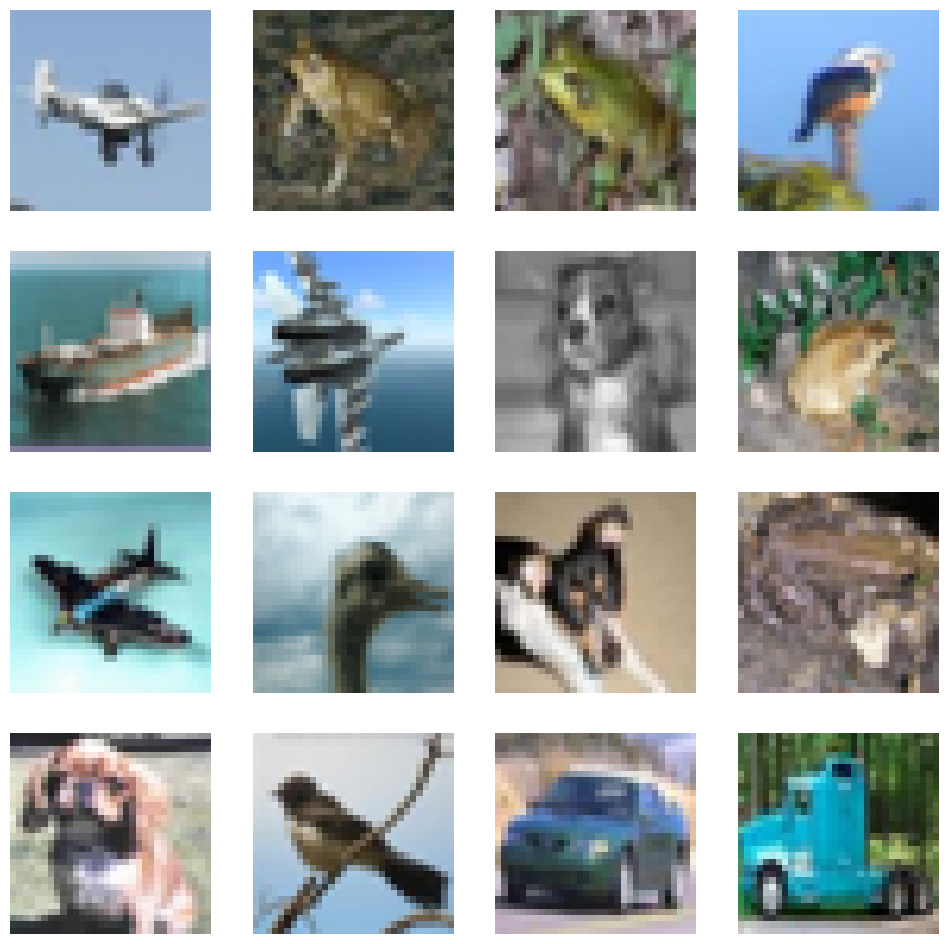

In [ ]:
show_images(x[:16])

In [ ]:
len(tds['test'].unique('label'))

[3, 8, 0, 6, 1, 9, 5, 7, 4, 2]

10

# DDPM with e^x scheduler | WandB callback with sample logging!
DS: CIFAR10

In [ ]:
# model
# loss
# callbacks
# optimization

# learner object.

model = UnetModel(in_channels = 3, out_channels = 3, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 4
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, weight_decay = 0.))

loss,epoch,train
0.196,0,train
0.055,0,eval
0.047,1,train
0.042,1,eval
0.041,2,train
0.039,2,eval
0.039,3,train
0.039,3,eval


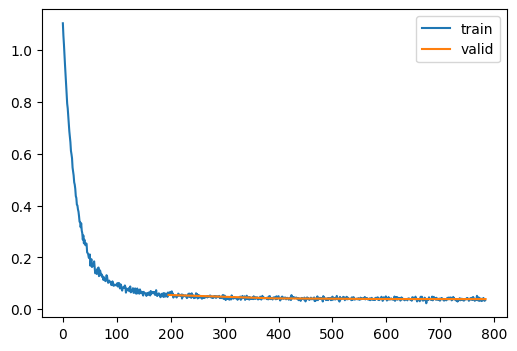

In [ ]:
learner.fit(epochs)

In [ ]:
model = learner.model

In [ ]:
samples = sample(model, cbs[-2], out_shape = (32, 3, 32, 32))

1000it [00:40, 24.58it/s]


In [ ]:
show_images(-samples[0][-1])

In [ ]:
sum(p.numel() for p in model.parameters())

6753859

In [ ]:
model = UnetModel(in_channels = 3, out_channels = 3)

In [ ]:
# model
# loss
# callbacks
# optimization

In [ ]:
class WandBCB(MetricsCB):
  def __init__(self, *args, project_name = '', **kwargs):
    super().__init__()
    self.c = 0
    self.run = wandb.init(
        project = project_name,
        config={
            "epochs": epochs,
        }
    )

  def after_batch(self, learn):
      super().after_batch(learn)
      self.c += 1
      self.run.log({'train_loss': learn.loss.item()} if learn.model.training else {'valid_loss': learn.loss.item()})
      if self.c%200 == 0: self.log_samples(learn)

  def log_samples(self, learn):
      out, _ = sample(learn.model, learn.cbs[-2], out_shape = (8, 3, 32, 32))
      tr = transforms.ToPILImage()
      self.run.log({"Intermediate_Gen": [wandb.Image(tr(i)) for i in -out[-1]]})

In [ ]:
model = UnetModel(in_channels = 3, out_channels = 3)
lr_max, epochs = 3e-03, 1
dls = DataLoaders.from_dd(tds, batch_size = 16, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          WandBCB(project_name = '274M param model - Iter 1'),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, weight_decay = 0., eps = 1e-05))

loss,epoch,train
0.045,0,train
0.035,0,eval


1000it [02:05,  7.95it/s]
1000it [02:07,  7.87it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.87it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.87it/s]
1000it [02:07,  7.87it/s]
1000it [02:07,  7.85it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.87it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.86it/s]
1000it [02:08,  7.79it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.86it/s]
1000it [02:07,  7.85it/s]
1000it [02:07,  7.86it/s]


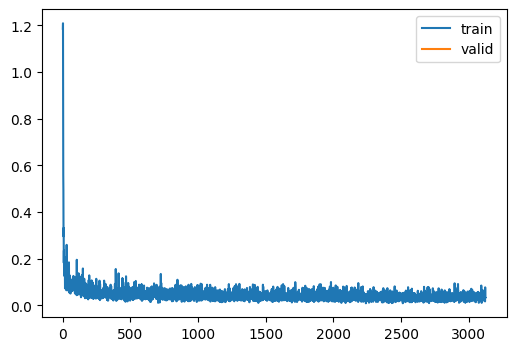

In [ ]:
learner.fit(epochs)

In [ ]:
out, _ = sample(learner.model, cbs[-2], out_shape=(16, 3, 32, 32))

1000it [03:13,  5.18it/s]


In [ ]:
x.device

device(type='cuda', index=0)

In [ ]:
x.shape

torch.Size([1, 3, 32, 32])

In [ ]:
noisified_img = noisify_img(cbs[-2], x_0 = x)

In [ ]:
type(noisified_img)

tuple

In [ ]:
noisified_img[0][0].shape, noisified_img[0][1].shape, noisified_img[0][0].device

(torch.Size([1, 3, 32, 32]), torch.Size([1]), device(type='cpu'))

In [ ]:
nx = (noisified_img[0][0].to(torch.device('cuda')), noisified_img[0][1].to(torch.device('cuda')))

In [ ]:
learner.model(nx)

tensor([[[[ 0.1823,  0.1869,  0.1949,  ...,  0.0887, -0.2089,  0.1185],
          [ 0.2084, -0.1546, -0.0268,  ..., -0.4127,  0.0694,  0.2177],
          [ 0.2639,  0.4000,  0.5454,  ...,  0.0796,  0.1341, -0.0254],
          ...,
          [ 0.2609,  0.4912,  0.3590,  ..., -0.1144,  0.0839, -0.1441],
          [ 0.0181,  0.1846, -0.0315,  ..., -0.0579,  0.1962, -0.1732],
          [-0.0433,  0.1719, -0.0497,  ...,  0.0361,  0.1776,  0.0714]],

         [[ 0.0819,  0.1919,  0.0916,  ...,  0.3038,  0.2708,  0.1247],
          [ 0.1884,  0.6957,  0.6259,  ...,  0.2017,  0.2460,  0.4465],
          [-0.2949,  0.3427,  0.3897,  ...,  0.7313,  0.3594,  0.2720],
          ...,
          [ 0.0911,  0.3625,  0.2153,  ..., -0.2589,  0.2462,  0.0453],
          [-0.0732,  0.2677,  0.2800,  ...,  0.0224,  0.2022,  0.1281],
          [-0.1282, -0.0921,  0.3180,  ...,  0.1560,  0.2625,  0.1644]],

         [[ 0.0980,  0.1333,  0.1518,  ...,  0.0227, -0.0456, -0.3803],
          [ 0.1983,  0.1002,  

In [ ]:
clean_mem()

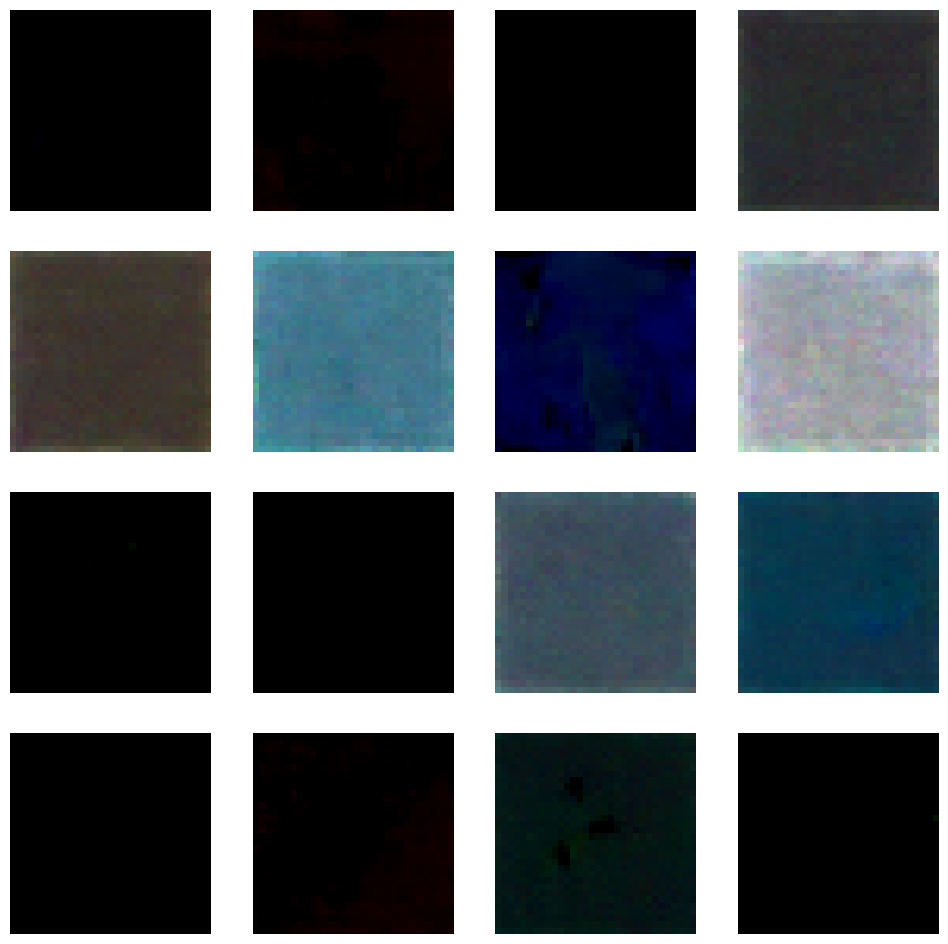

In [ ]:
show_images(-out[-1])

In [ ]:
del dls
del model
del learner

clean_mem()

# FID and KID - For performance evaluation.

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi_dd(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)*2. - 1.) for o in b['image']]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi_dd)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

In [ ]:
def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'


class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = GeneralRelu, p = 0.1, dropout_func = nn.Dropout2d(0.2)):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.5, p = 1.0), v2.RandomRotation(degrees=(0, 360))], p=0.8):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p = p)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

def get_model(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for i in range(1, len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

act = partial(GeneralRelu, leak = 0.1, sub = 0.1)
iw = partial(init_weights, leaky = 0.1)

  # 1, 32, 32 - 16, 32, 32
  # 16, 32, 32 - 32, 16, 16
  # 32, 16, 16 - 64, 8, 8 - 128, 4, 4 - 256, 2, 2

In [ ]:
max_lr, epochs = 2e-02, 25

model = get_model(norm = nn.BatchNorm2d, act = act, p = 0.1)
dls = DataLoaders.from_dd(tds, 2048, num_workers=2)

cbs = [
          DataAugCB([RandCopy()]),
          ProgressCB(plot = False),
          MetricsCB(accuracy = MulticlassAccuracy()),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, epochs = epochs, steps_per_epoch = len(dls.train))),
          DropoutCB(drop_sched = DropoutScheduler(epochs = epochs, min = 0.1, max = 0.5))
      ]
learner = AccLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# 93.8 pct acc

In [ ]:
torch.save(learner.model, mdl_path/'data_aug_fid.pkl')

In [ ]:
freche_model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))

In [ ]:
class FID:
  def __init__(self, model = None, targ = x):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model

  def _get_means(self, x, targ):
    index = x.shape[0]
    inp = torch.cat((x, targ))
    with torch.no_grad(): acts = self.model(inp)
    i, t = acts[:index], acts[index:]
    return i.mean(0), i.T.cov(), t.mean(0), t.T.cov()

  def __call__(self, x, targ):
    i_means, i_cov, t_means, t_cov = self._get_means(x, targ)
    csr = torch.tensor(sqrtm(i_cov@t_cov, blocksize = 256).real)
    return (((i_means-t_means)**2).sum() + i_cov.trace() + t_cov.trace() - 2*csr.trace()).item()

In [ ]:
fid = FID(freche_model)
dist = fid(x,x)
dist

-0.072235107421875

# -1 to 1 scaling and experimentation

In [ ]:
freche_model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
del freche_model[-1]
del freche_model[-1]
del freche_model[-1]

In [ ]:
from miniai.fid import *

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi_dd(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)*2. - 1.) for o in b['image']]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi_dd)
dls = DataLoaders.from_dd(tds, batch_size = 128, num_workers=2)

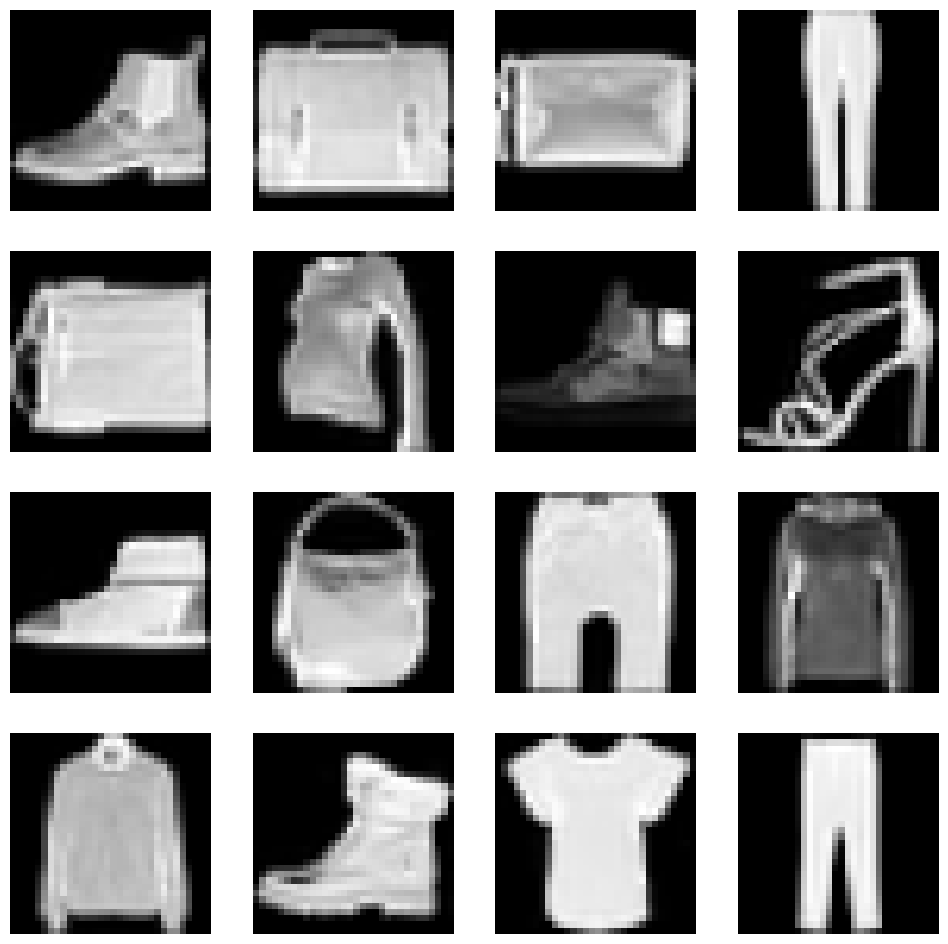

In [ ]:
# Originals
x, y = next(iter(dls.train))
show_images(x[:16])

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))

In [ ]:
learner.fit(epochs)

KeyboardInterrupt: 

In [ ]:
out, _ = sample(learner.model, cb = cbs[-2], out_shape = (256, 1, 32, 32))

1000it [02:54,  5.74it/s]


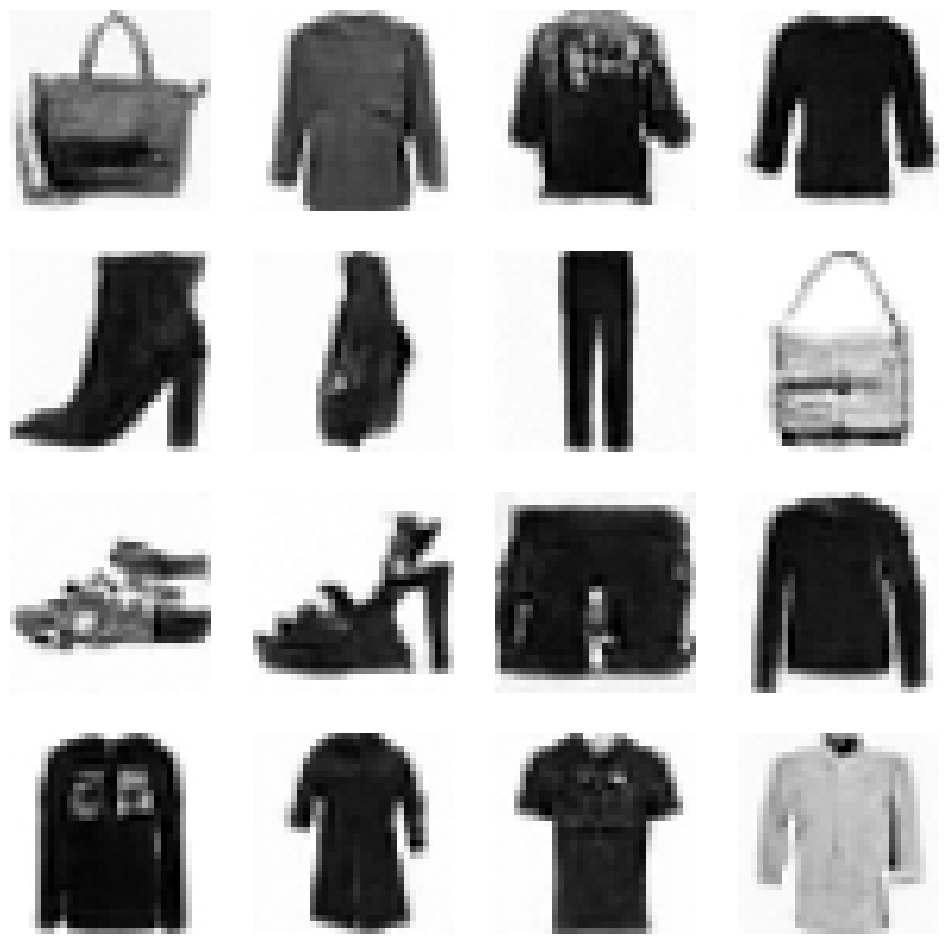

In [ ]:
show_images(-out[-1][:16])

In [ ]:
class FID:
  def __init__(self, model = None, targ = x):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

In [ ]:
x, y = next(iter(dls.train)) # Ensuring the batch size is same across targets and samples

In [ ]:
fid = FID(targ = x.cpu())
fid(-out[-1].cpu())

109.02159881591797

In [ ]:
learner.model

In [ ]:
torch.save(learner.model.state_dict(), mdl_path/'ddpm_rescaled_1_1.pkl')

In [ ]:
# DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1))
nm = torch.load(mdl_path/'ddpm_rescaled_1_1.pkl')
nmm = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
nmm.load_state_dict(nm)

<All keys matched successfully>

# -1 to 1 scaling and experimentation

In [ ]:
freche_model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
del freche_model[-1]
del freche_model[-1]
del freche_model[-1]

In [ ]:
from miniai.fid import *

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi_dd(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)*2. - 1.) for o in b['image']]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi_dd)
dls = DataLoaders.from_dd(tds, batch_size = 128, num_workers=2)

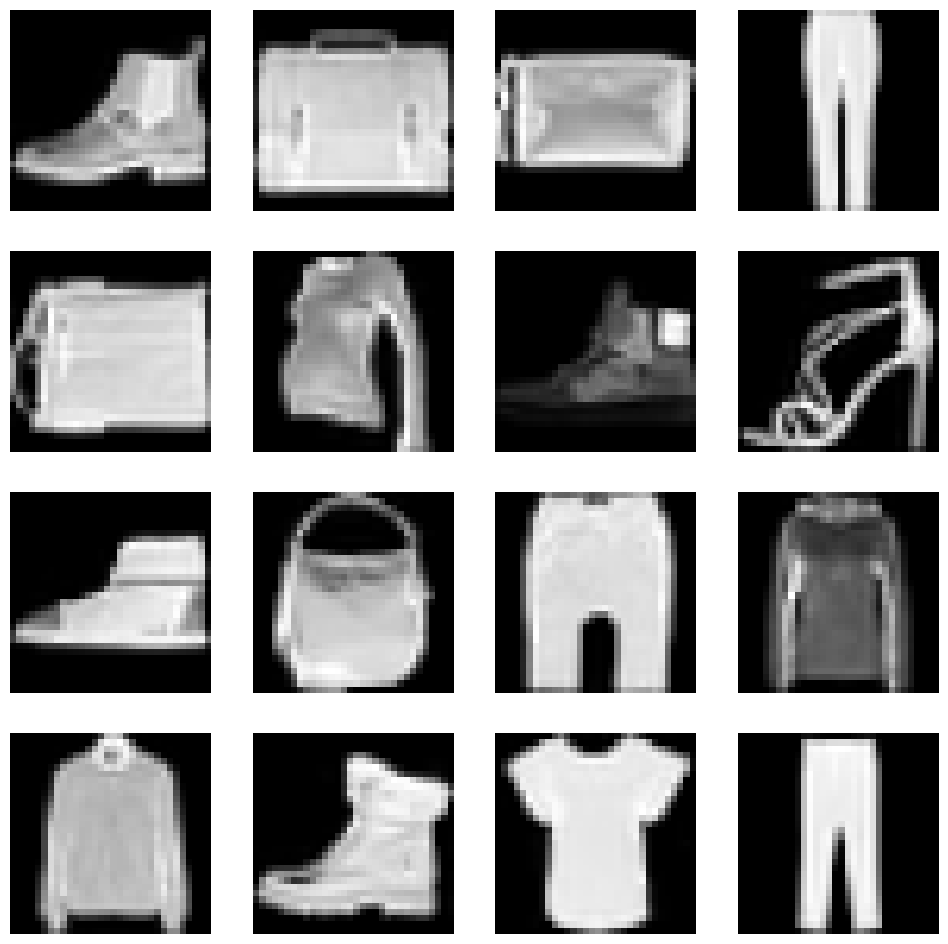

In [ ]:
# Originals
x, y = next(iter(dls.train))
show_images(x[:16])

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
# learner.fit(epochs)

In [ ]:
learner.fit(epochs)

KeyboardInterrupt: 

In [ ]:
out, _ = sample(learner.model, cb = cbs[-2], out_shape = (256, 1, 32, 32))

1000it [02:54,  5.74it/s]


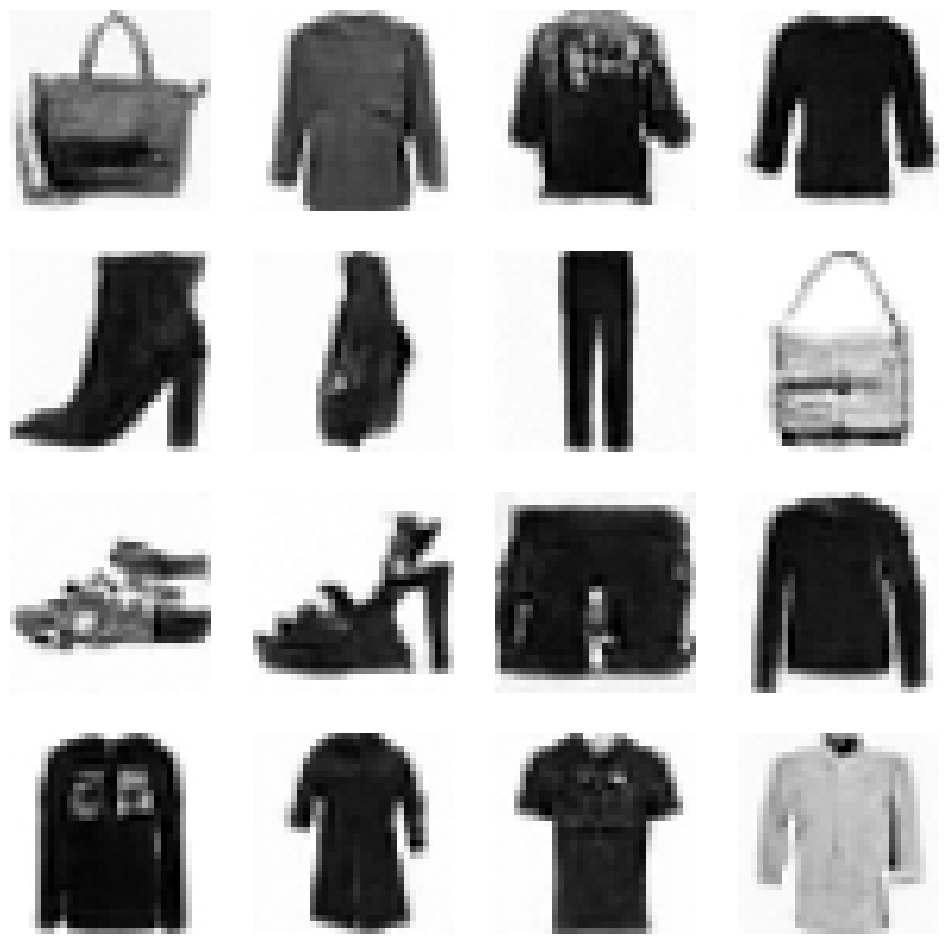

In [ ]:
show_images(-out[-1][:16])

In [ ]:
class FID:
  def __init__(self, model = None, targ = x):
    if not model:
      model = torch.load(mdl_path/'data_aug_fid.pkl', map_location=torch.device('cpu'))
      del model[-1]
      del model[-1]
      del model[-1]

    self.model = model
    self.t_mean, self.t_cov = self._get_stats(targ)

  def _get_stats(self, x):
    index = x.shape[0]
    inp = x
    with torch.no_grad(): acts = self.model(inp)
    return acts.mean(0), acts.T.cov()

  def __call__(self, x):
    i_means, i_cov = self._get_stats(x)
    csr = torch.tensor(sqrtm(i_cov@self.t_cov, blocksize = 256).real)
    return (((i_means-self.t_mean)**2).sum() + i_cov.trace() + self.t_cov.trace() - 2*csr.trace()).item()

In [ ]:
x, y = next(iter(dls.train)) # Ensuring the batch size is same across targets and samples

In [ ]:
fid = FID(targ = x.cpu())
fid(-out[-1].cpu())

109.02159881591797

In [ ]:
learner.model

In [ ]:
torch.save(learner.model.state_dict(), mdl_path/'ddpm_rescaled_1_1.pkl')

# FID Check with range 0 to 1

loss,epoch,train
0.121,0,train
0.047,0,eval
0.040,1,train
0.038,1,eval
0.034,2,train
0.033,2,eval
0.031,3,train
0.032,3,eval
0.029,4,train
0.030,4,eval


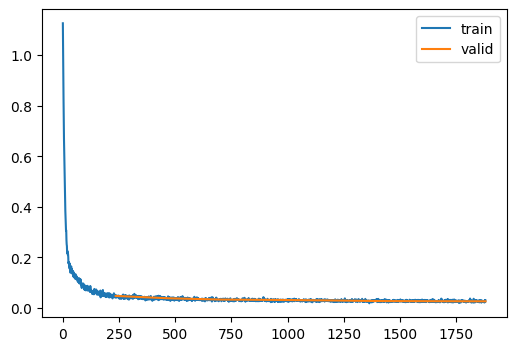

In [ ]:
@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) for o in b['image']]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

1000it [02:55,  5.70it/s]


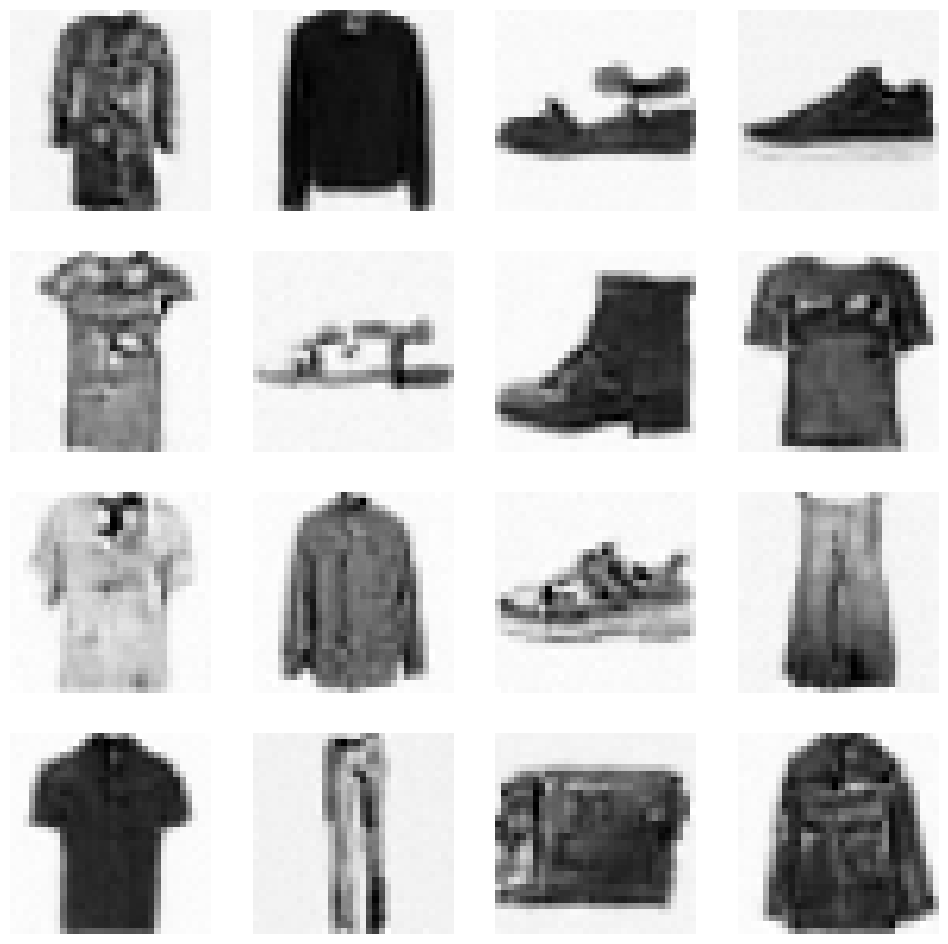

In [ ]:
out, _ = sample(learner.model, cb = cbs[-2], out_shape = (256, 1, 32, 32))
show_images(-out[-1][:16])

In [ ]:
x.device

device(type='cuda', index=0)

In [ ]:
x, y = next(iter(dls.train))
fid = FID(freche_model, x.cpu())
fid(-out[-1])

30.399986267089844

# -0.5 to 0.5

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi_v2(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi_v2)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
torch.save(learner.model, mdl_path/'ddpm_rescaled_5_5.pkl')

1000it [02:53,  5.77it/s]


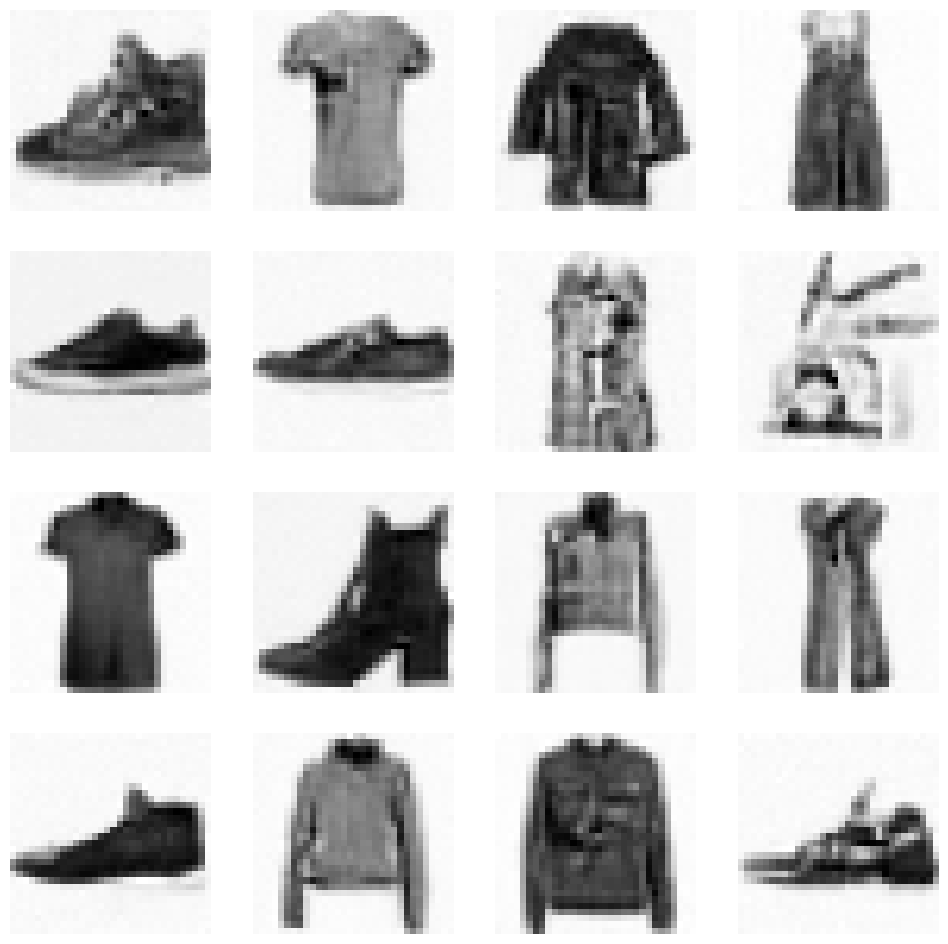

In [ ]:
out, _ = sample(learner.model, cb = cbs[-2], out_shape = (256, 1, 32, 32))
show_images(-out[-1][:16])

In [ ]:
x, y = next(iter(dls.train))
fid = FID(freche_model, x.cpu())
fid(-out[-1])

28.00634002685547

In [ ]:
from google.colab import runtime
runtime.unassign()

# Trying to figureout why things are the way they are!

In [ ]:
# We have an image
# Batchify that image
# Noisify the image with random series of timesteps multiples of 99 - batch of 10 samples
# Calculate the noise
# We have xt - noisifid image, alpha_bar_t - using timestep, actual noise - Y(Label), Predicted noise(Yhat)
# Calculate actual x0 and derived x0
# Monitor the metrics for each timestep - Plot the values
# Try and figure out things!

In [ ]:
def noisify_img_v2(cb_obj, x_0, ts = None):

  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = ts if ts != None else torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  # xo = (xt - (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)*noise)/cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)

  return (x_t, ts), noise

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)
@inplace
def transformi_dd(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)*2. - 1.) for o in b['image']]

tds = dsd.with_transform(transformi_dd)
dls = DataLoaders.from_dd(tds, batch_size = 128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
x, y = next(iter(dls.train))
imgs = x.cpu()[:11]

In [ ]:
x.min(), x.max()

(tensor(-1.), tensor(1.))

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
model.load_state_dict(torch.load(mdl_path/'ddpm_rescaled_1_1.pkl'))

def get_x_0(xt, ts, cb, act_noise):
  return (xt - (1 - cb.alpha_bar[ts]).sqrt()[:, None, None, None]*act_noise)/cb.alpha_bar[ts].sqrt()[:, None, None, None]

In [ ]:
imgs.shape

torch.Size([11, 1, 32, 32])

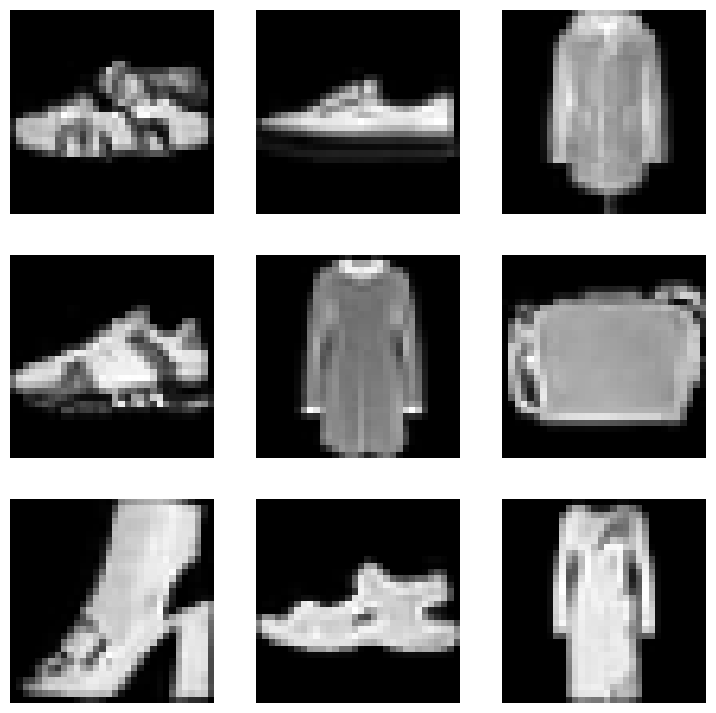

In [ ]:
show_images(imgs[:9])

In [ ]:
ts = torch.tensor(range(0, 1000, 99))
get_exp(x_start = -2, x_end = 1)
cb = DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1))
(xt, ts), ys = noisify_img_v2(cb, imgs, ts = ts)
noise_preds = model((xt, ts))

In [ ]:
actual_x = get_x_0(xt, ts, cb, ys)
derived_x = get_x_0(xt, ts, cb, noise_preds)

In [ ]:
def print_stats(x): print(x.mean(), x.std(), x.min(), x.max())

In [ ]:
show_images(xt[:9], titles = list(ts[:9]))

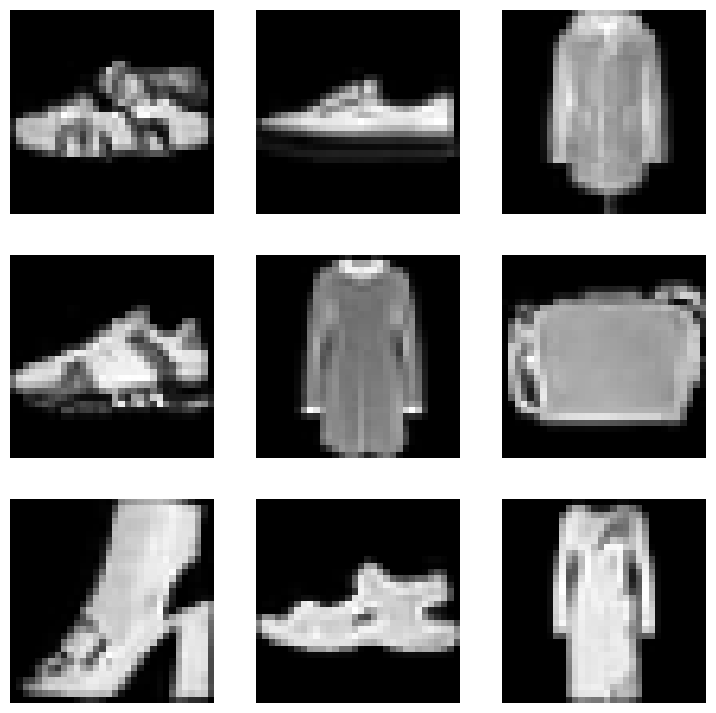

In [ ]:
show_images(actual_x[:9])

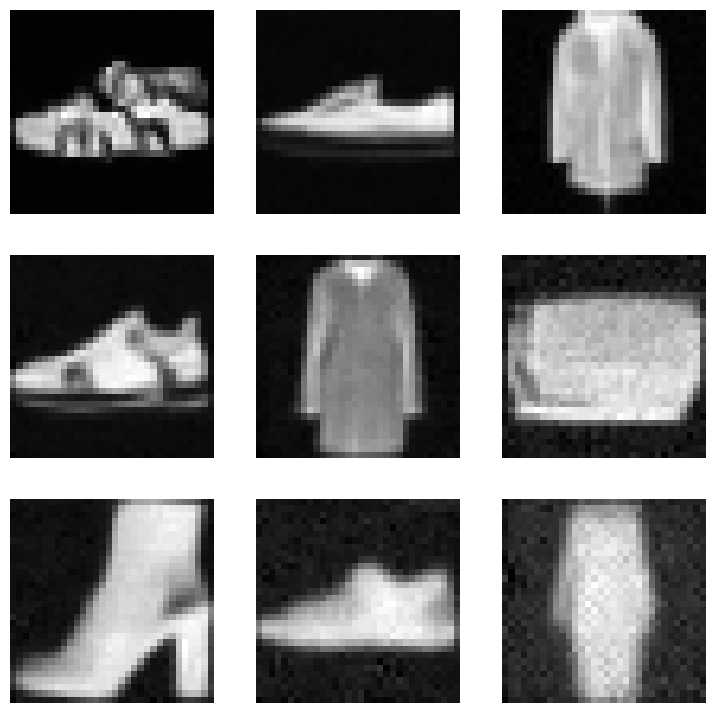

In [ ]:
show_images(derived_x[:9])

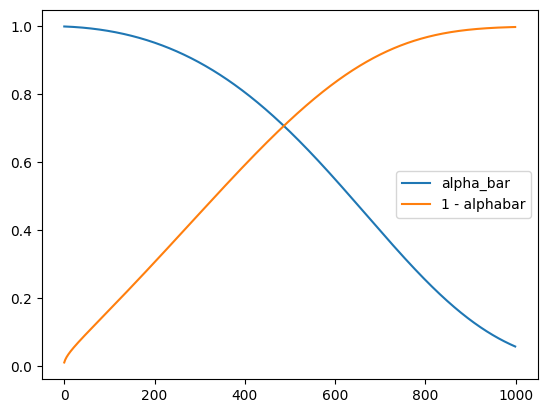

In [ ]:
plt.plot(cb.alpha_bar.sqrt(), label = 'alpha_bar')
plt.plot((1. - cb.alpha_bar).sqrt(), label = '1 - alphabar')
plt.legend()
plt.show()

1000it [05:35,  2.98it/s]


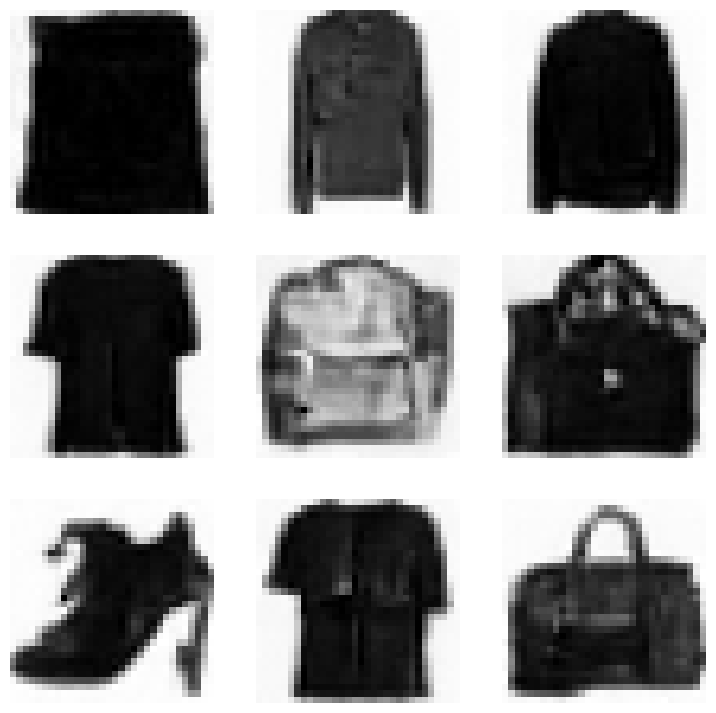

In [ ]:
out, (c1, c2) = sample(model, cb, out_shape = (9, 1, 32, 32))
show_images(-out[-1])

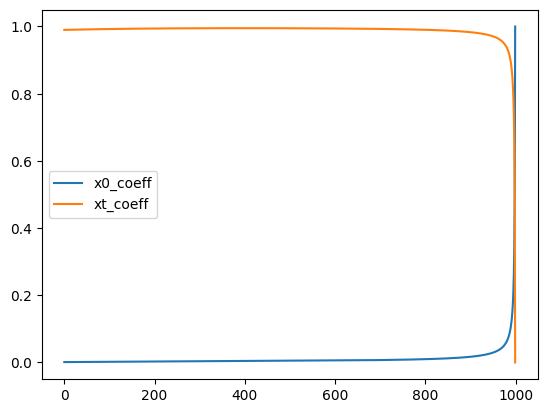

In [ ]:
plt.plot(c1, label = 'x0_coeff')
plt.plot(c2, label = 'xt_coeff')
plt.legend()
plt.show()

In [ ]:
torch.tensor(c1).max(), torch.tensor(c1).min(), torch.tensor(c2).max(), torch.tensor(c2).min()

(tensor(1.), tensor(0.0012), tensor(0.9950), tensor(0.))

In [ ]:
space = torch.linspace(-2, 3, 1000)
nc1 = torch.exp(space)
nc2 = nc1.max() - nc1
nc1 = scaler(nc1, torch.tensor(c1).min(), torch.tensor(c1).max())
nc2 = scaler(nc2, torch.tensor(c2).min(), torch.tensor(c2).max())

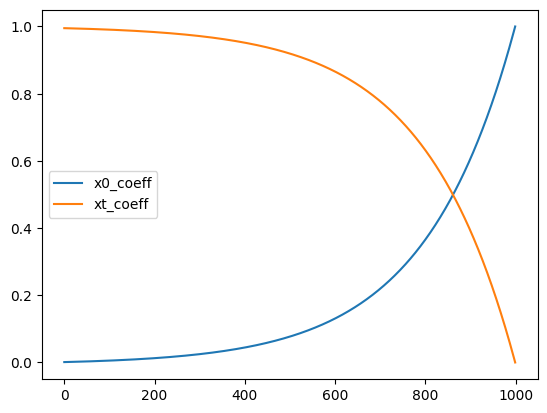

In [ ]:
plt.plot(nc1, label = 'x0_coeff')
plt.plot(nc2, label = 'xt_coeff')
plt.legend()
plt.show()

In [ ]:
model.to(torch.device('cuda'))

In [ ]:
@torch.no_grad()
def sample_exp(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32), c1 = None, c2 = None):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):

    # if ts%3 != 0: continue

    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t if c1 == None else list(reversed(c1))[ts]
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t if c2 == None else list(reversed(c2))[ts]

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x0_hat.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, (x0_coeffs, xt_coeffs)

In [ ]:
out, coeffs = sample_exp(model.to(torch.device('cuda')), cb, out_shape = (256, 1, 32, 32), c1 = nc1, c2 = nc2)

1000it [03:00,  5.55it/s]


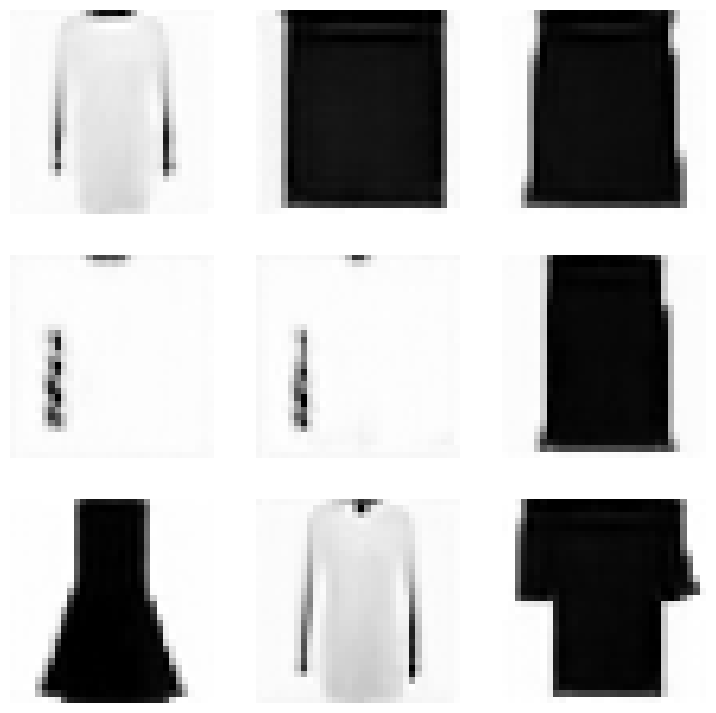

In [ ]:
show_images(-out[-1][:9])

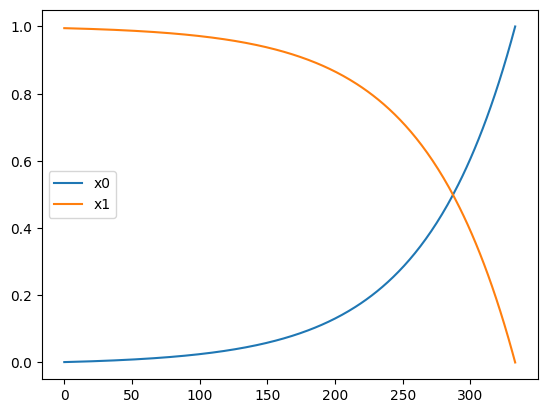

In [ ]:
plt.plot(coeffs[0], label = 'x0')
plt.plot(coeffs[1], label = 'x1')
plt.legend()
plt.show()

In [ ]:
ch = [i[0] for i in out]

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML
from fastcore.foundation import L

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(ch[i], ax=ax, animated=True).get_images()
r = L.range(10,950, 2)+L.range(950,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))


Using matplotlib backend: <object object at 0x7db35fa0b680>


**-0.5 to 0.5 scaled data**

In [ ]:
nmodel = torch.load(mdl_path/'ddpm_rescaled_5_5.pkl', map_location=torch.device('cpu'))
@inplace
def transformi_2(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]
tds = dsd.with_transform(transformi_2)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

In [ ]:
x, y = next(iter(dls.train))
nimgs = x[:11]

In [ ]:
(nxt, ts), nys = noisify_img_v2(cb, nimgs, ts = ts)
n_noise_preds = nmodel((nxt, ts))

In [ ]:
n_noise_preds.mean(), n_noise_preds.std()

(tensor(-0.0021, grad_fn=<MeanBackward0>),
 tensor(0.9654, grad_fn=<StdBackward0>))

In [ ]:
nactual_x = get_x_0(nxt, ts, cb, nys)
nderived_x = get_x_0(nxt, ts, cb, n_noise_preds)

In [ ]:
F.mse_loss(nys, n_noise_preds)

tensor(0.0626, grad_fn=<MseLossBackward0>)

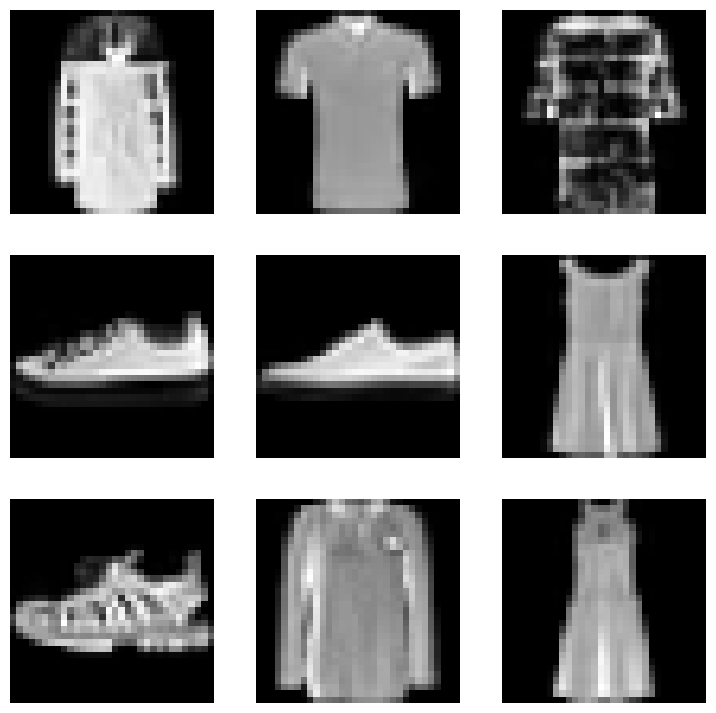

In [ ]:
show_images(nactual_x[:9])

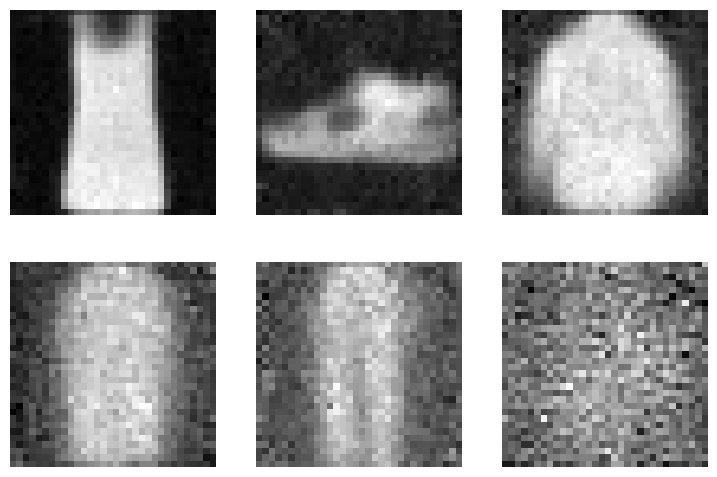

In [ ]:
show_images(nderived_x[5:])

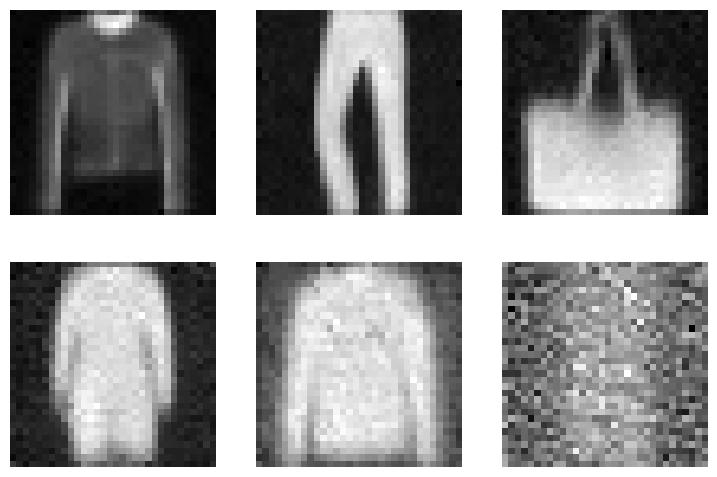

In [ ]:
show_images(derived_x[5:])

In [ ]:
#Smoothen out the curves

In [ ]:
@torch.no_grad()
def sample(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x0_hat.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, (x0_coeffs, xt_coeffs)

In [ ]:
out, (c1, c2) = sample(model, cb, out_shape = (9, 1, 32, 32))

# Fiddling with Beta range

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_cosine_schedule(max = 0.01)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
# learner.fit(epochs)

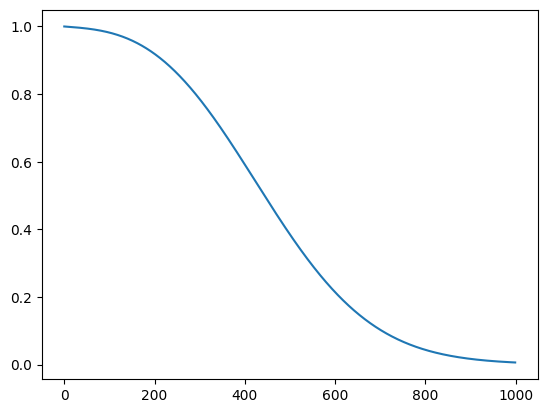

In [ ]:
plt.plot(cbs[-2].alpha_bar)

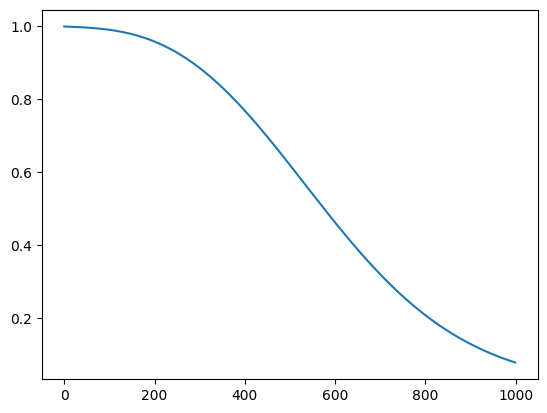

In [ ]:
plt.plot(cbs[-2].alpha_bar.sqrt())

In [ ]:
cbs[-2].alpha_bar.sqrt().min()

tensor(0.0793)

loss,epoch,train
0.137,0,train
0.050,0,eval
0.043,1,train
0.041,1,eval
0.037,2,train
0.035,2,eval
0.033,3,train
0.033,3,eval
0.031,4,train
0.030,4,eval


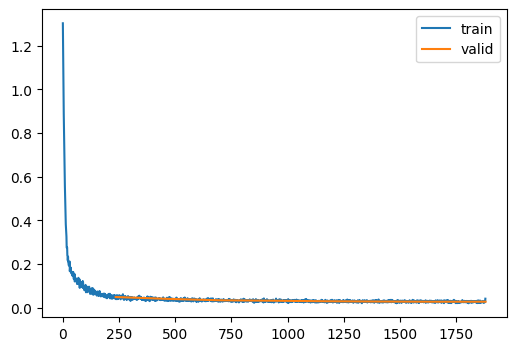

In [ ]:
learner.fit(epochs)

In [ ]:
out, coeffs = sample(learner.model, cbs[-2], (256, 1, 32, 32))

1000it [02:51,  5.83it/s]


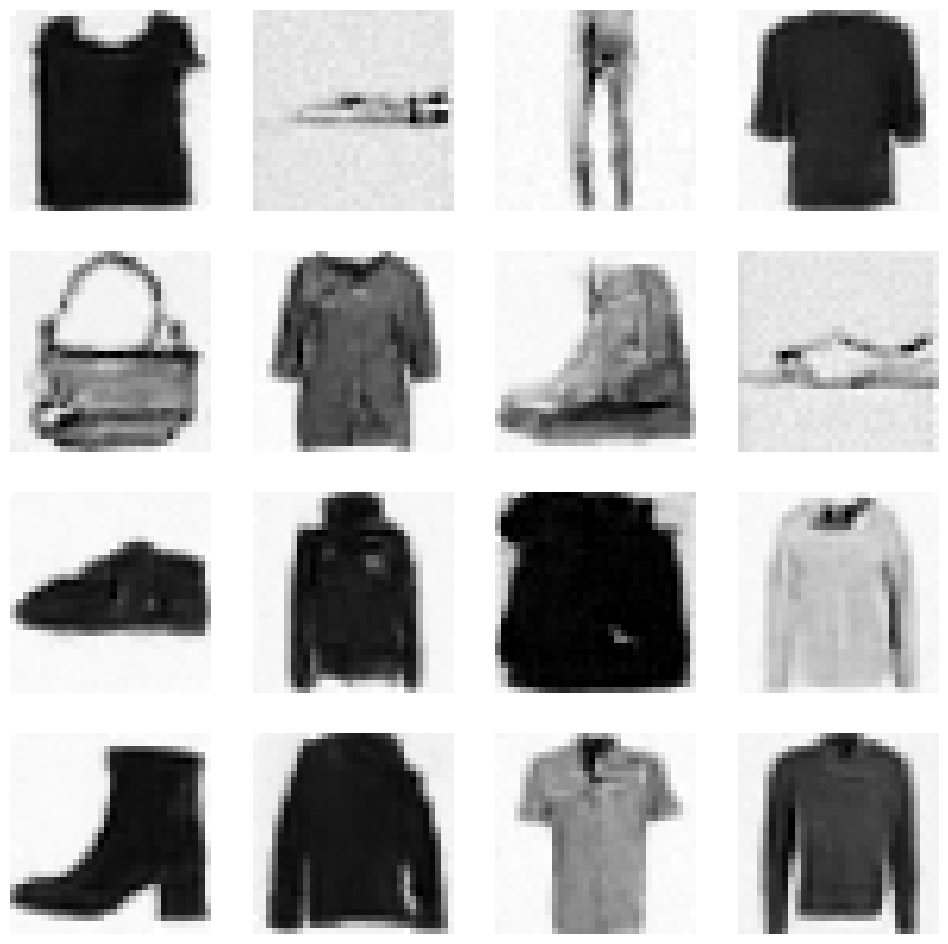

In [ ]:
show_images(-out[-1][:16])

In [ ]:
x, y = next(iter(dls.train))

In [ ]:
fid = FID(targ = x.cpu())

In [ ]:
fid((-out[-1]).cpu())

23.806838989257812

loss,epoch,train
0.028,0,train
0.029,0,eval
0.029,1,train
0.029,1,eval
0.028,2,train
0.029,2,eval
0.028,3,train
0.029,3,eval
0.027,4,train
0.028,4,eval


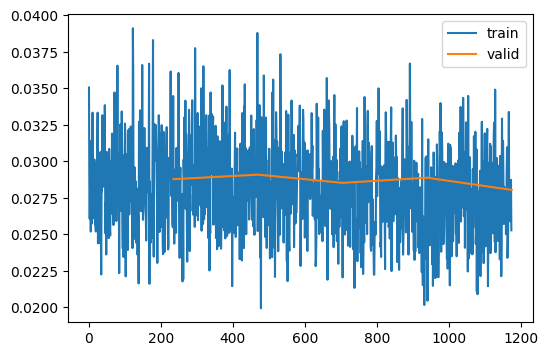

In [ ]:
lr_max, epochs = 3e-04, 5
learner.cbs[-1] = BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
learner.fit(epochs)

In [ ]:
torch.save(learner.model.state_dict(), mdl_path/'ddpm_v3_0_001.pt')

In [ ]:
out, coeff = sample(model, cbs[-2], (256, 1, 32, 32))

1000it [02:47,  5.97it/s]


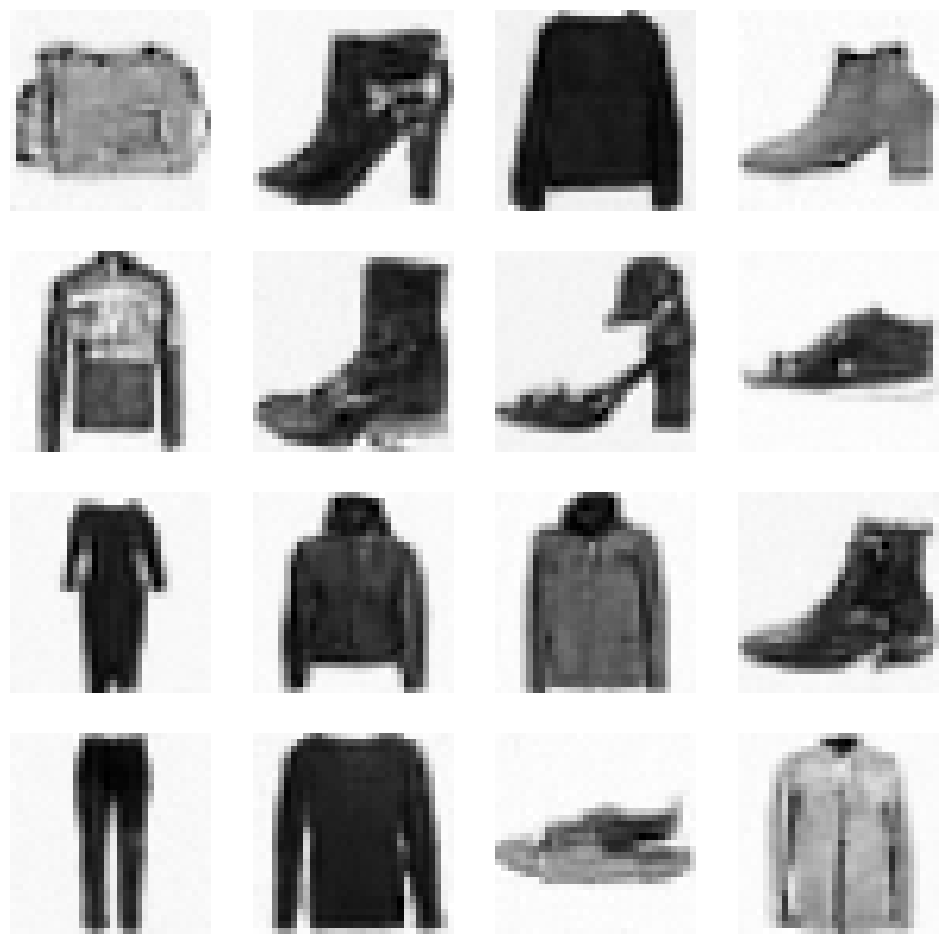

In [ ]:
show_images(-out[-1][:16])

In [ ]:
fid((-out[-1]).cpu())

21.642242431640625

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
model.load_state_dict(torch.load(mdl_path/'ddpm_v3_0_001.pt'))

<All keys matched successfully>

# Just for DDIM - With Linear Beta Schedule

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 15
dls = DataLoaders.from_dd(tds, 256, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = torch.linspace(0.0001, 0.01, 1000)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
# learner.fit(epochs)

loss,epoch,train
0.113,0,train
0.046,0,eval
0.036,1,train
0.032,1,eval
0.029,2,train
0.028,2,eval
0.026,3,train
0.025,3,eval
0.025,4,train
0.025,4,eval


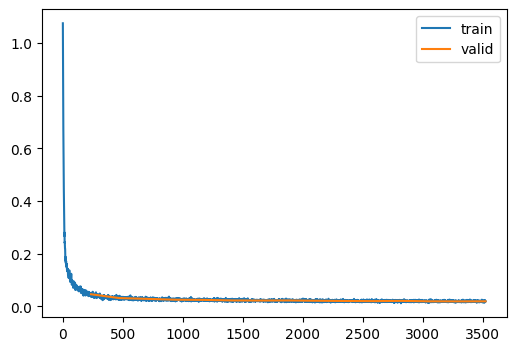

In [ ]:
learner.fit(epochs)

In [ ]:
torch.save(learner.model.state_dict(), mdl_path/'ddim_v1_0_001_linear.pt')

# DDIM

In [ ]:
from diffusers import DDIMScheduler

In [ ]:
ddim_scheduler = DDIMScheduler(333, beta_end = 0.01, beta_schedule = 'linear', clip_sample = False)

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b): b['image'] = [(resize(to_tensor(o), (32, 32), antialias = True)) - 0.5 for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
model.load_state_dict(torch.load(mdl_path/'ddim_v1_0_001_linear.pt'))

<All keys matched successfully>

In [ ]:
x, y = next(iter(dls.train))

In [ ]:
ds = DDIMScheduler(1000, beta_end=0.01)

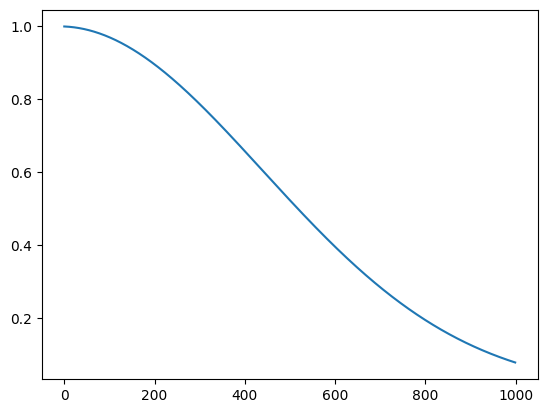

In [ ]:
plt.plot(ds.alphas_cumprod.sqrt())

In [ ]:
ds.set_timesteps(100)
ds.timesteps

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

In [ ]:
ds = DDIMScheduler(1000, beta_end=0.01)

def get_x0(xt, np, alpha_bar): return (xt - (1. - alpha_bar).sqrt()*np)/(alpha_bar.sqrt())

def ddim_sample(model, n_steps, out_shape = (256, 1, 32, 32), sched = ds):
  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)

  for cts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([cts]*out_shape[0]).to(model.device)))

    if cts in [10, 0]: st()

    xt = sched.step(np, cts, sample = xt, eta = 0.8, return_dict = False)[0]
  return xt

In [ ]:
model = model.to(torch.device('cuda'))

In [ ]:
# 100 steps - 4.47
# 1000 steps - 6.07
# 333 steps - 5.87
out = ddim_sample(model, 100)

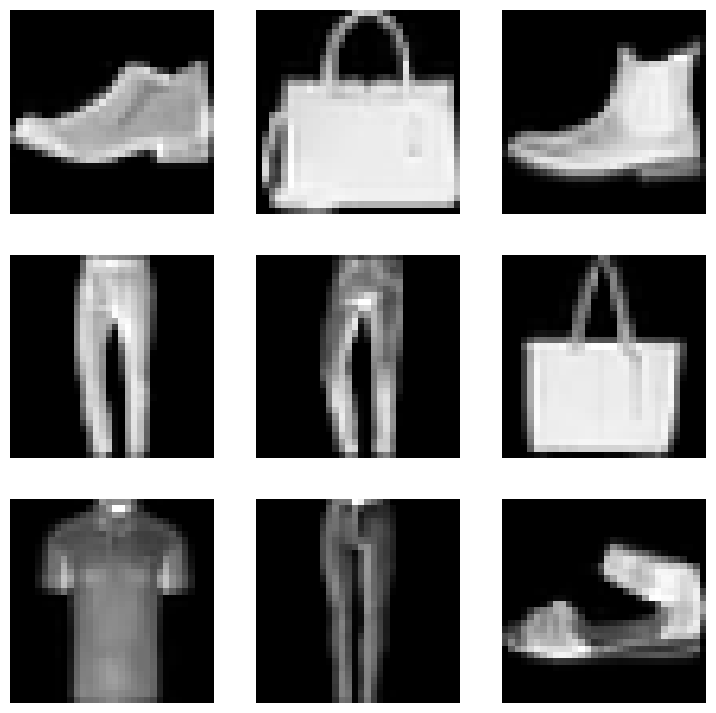

In [ ]:
show_images(x[:9])

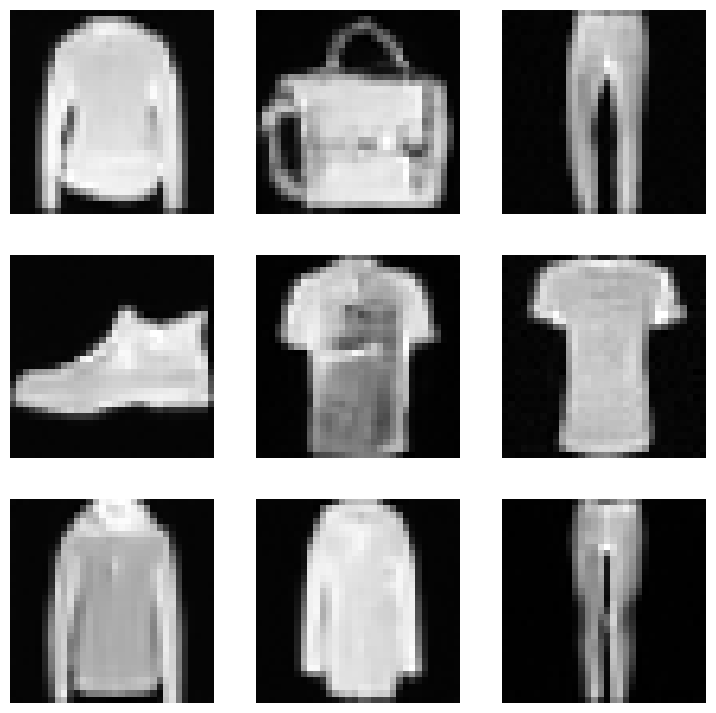

In [ ]:
# out = (out*2).clamp(-1,1)
show_images(out[:9])

In [ ]:
x.device, x.shape

(device(type='cpu'), torch.Size([256, 1, 32, 32]))

In [ ]:
fid = FID(targ = x)

In [ ]:
fid(out.cpu())

4.847541809082031

In [ ]:
class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin'):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

In [ ]:
class DDIM_Scheduler: # This is only for sampling purposes

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, self.num_timesteps, skips)))

  def step(self, xt, np, cts, eta = 0.8):

    a_bar_t, a_bar_t_1 = self.noise_cb.alpha_bar[cts], self.noise_cb.alpha_bar[cts + 1] if cts > 0 else torch.tensor(1)
    b_bar_t, b_bar_t_1 = (1. - a_bar_t), (1. - a_bar_t_1)

    if cts == 0: st()

    x0_hat = (xt - b_bar_t_1.sqrt()*np)/(a_bar_t.sqrt())

    if cts == 0: return x0_hat

    sig = (b_bar_t/b_bar_t_1).sqrt() * (1. - (a_bar_t_1/a_bar_t)).sqrt() * eta

    xt = a_bar_t_1.sqrt()*x0_hat + (b_bar_t_1 - sig**2).sqrt()*np
    if cts > 0: xt += sig*torch.randn(xt.shape).to(xt.device)
    return xt

def ddim_sample_v2(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_Scheduler(DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)))):
  sched.set_timesteps(n_steps, 10)

  xt = torch.randn(out_shape).to(model.device)
  for cts in tqdm(ds.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([cts]*out_shape[0]).to(model.device)))
    # x0_hat = get_x0(xt, np, ds.alphas_cumprod[cts])
    xt = sched.step(xt, np, cts)
  return xt

In [ ]:
model = model.to(torch.device('cuda'))

In [ ]:
mout = ddim_sample_v2(model, 100)

 99%|█████████▉| 99/100 [00:16<00:00,  6.16it/s]

> <ipython-input-53-39035d849a7f>(16)step()
     15 
---> 16     x0_hat = (xt - b_bar_t_1.sqrt()*np)/(a_bar_t.sqrt())
     17 

ipdb> c


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


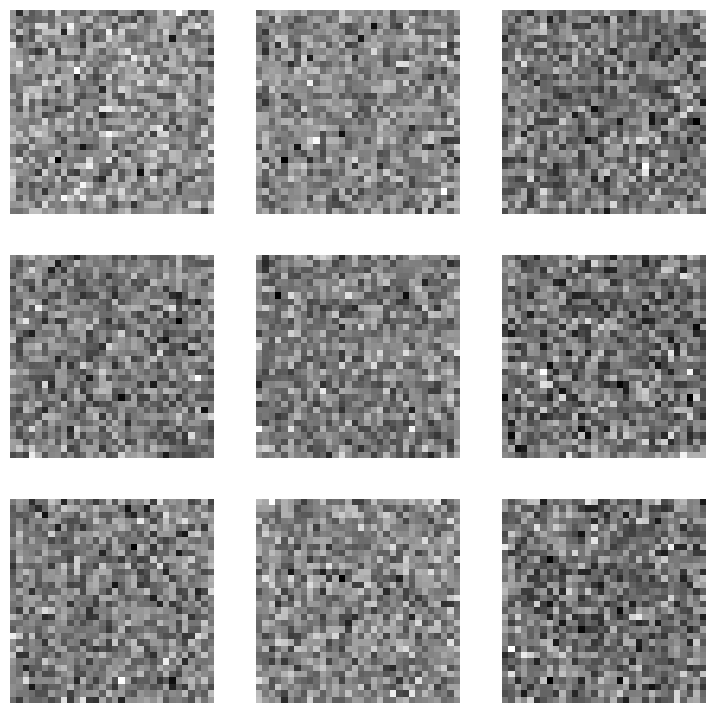

In [ ]:
show_images(mout[:9])

In [ ]:
abar = DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)).alpha_bar

@torch.no_grad()
def j_sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(tqdm(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model((x_t,t))
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1)) # wrong
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

In [ ]:
samples = j_sample(ddim_step, model, (256, 1, 32, 32), 1000, 1-)

100%|██████████| 334/334 [00:55<00:00,  5.99it/s]


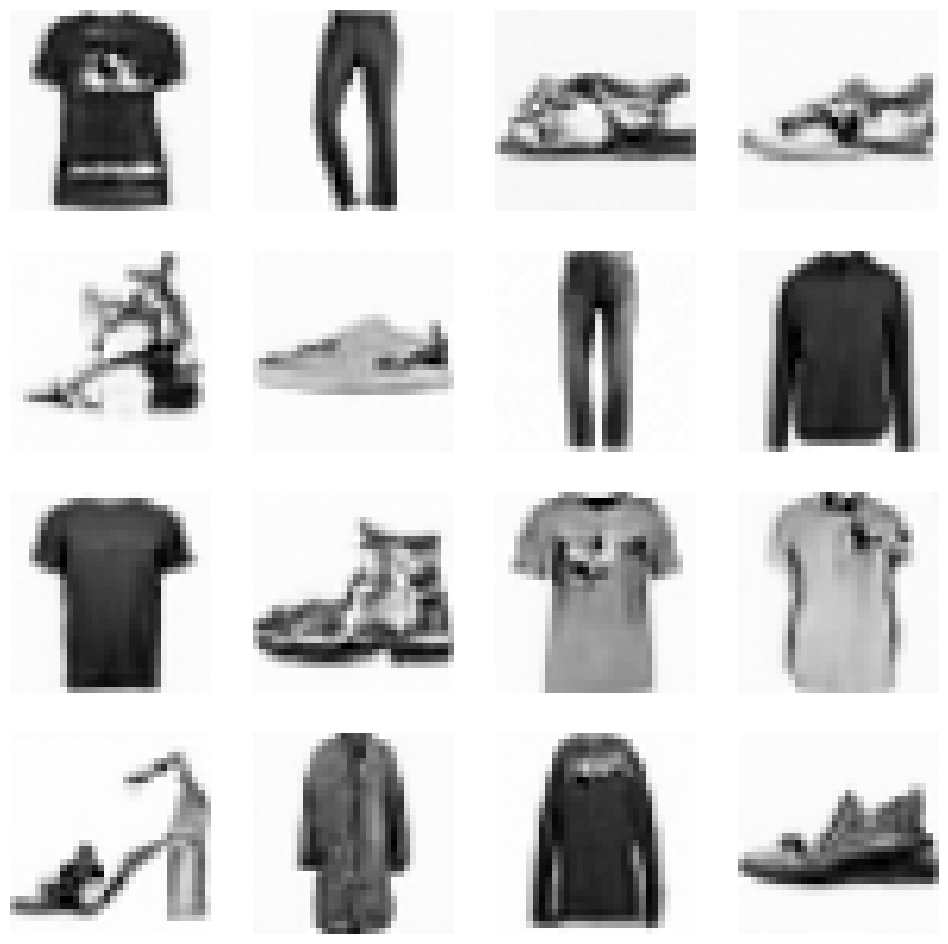

In [ ]:
show_images(-samples[-1][:16])

In [ ]:
x.shape

torch.Size([256, 1, 32, 32])

In [ ]:
fid = FID(targ = x)
fid((-samples[-1]))

23.55846405029297

In [ ]:
class DDIM_SchedulerV2: # This is only for sampling purposes

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def step(self, xt, np, cts, eta = 0.8):

    a_bar_t, a_bar_t_1 = self.noise_cb.alpha_bar[cts], self.noise_cb.alpha_bar[cts + 1] if cts > 0 else torch.tensor(1)
    b_bar_t, b_bar_t_1 = (1. - a_bar_t), (1. - a_bar_t_1)

    if cts == 0: st()

    x0_hat = (xt - b_bar_t_1.sqrt()*np)/(a_bar_t.sqrt())

    # if cts == 0: return x0_hat

    sig = (b_bar_t/b_bar_t_1).sqrt() * (1. - (a_bar_t_1/a_bar_t)).sqrt() * eta

    xt = a_bar_t_1.sqrt()*x0_hat + (b_bar_t_1 - sig**2).sqrt()*np
    if cts > 0: xt += sig*torch.randn(xt.shape).to(xt.device)
    return xt

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step_new(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)

    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)


    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample_v3(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)))):

  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    xt = sched.step_new(xt, np, ts, eta = 0.8)
  return xt


In [ ]:
mout = ddim_sample_v3(model, 100)

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


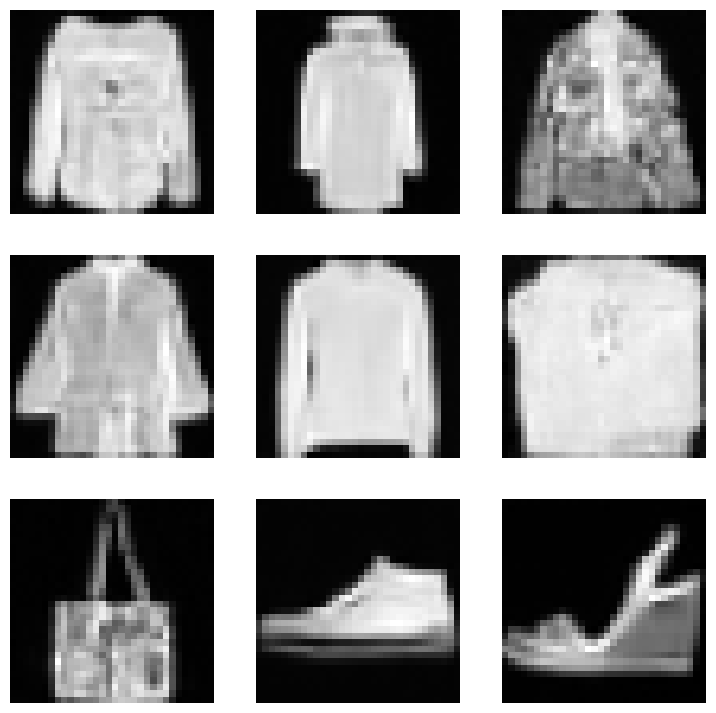

In [ ]:
show_images(mout[18:27])

In [ ]:
fid(mout.cpu())

4.115715026855469

# Checking the DDIM Sampling with model that is trained on -1 to 1 images

In [ ]:
class DDIM_Scheduler: # This is only for sampling purposes - All bugs fixed!

  def __init__(self, noise_cb): self.noise_cb = noise_cb

  def set_timesteps(self, ts, skips = 10):
    self.skips = skips
    self.num_timesteps = ts
    self.timesteps = reversed(torch.tensor(range(0, 1000, skips)))

  def _get_alphas(self, ts):

    def _get_alpha(ts, alpha_bar = self.noise_cb.alpha_bar):
      return alpha_bar[ts] if ts >= 0 else torch.tensor(1.)
    prev_ts = ts - self.skips
    return _get_alpha(ts), _get_alpha(prev_ts)

  def _get_variance(self, alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev):
    return (beta_bar_prev / beta_bar) * (1 - alpha_bar / alpha_bar_prev)

  def step(self, xt, np, ts, eta = 0.5):
    # get the current time step and previous timesteps
    # Get alpha bar t and alpha bar t - steps and beta bar t and beta bar t - steps
    # get the x0 hat based on the noise predict
    # calculate the xt-steps using the updated formula

    alpha_bar, alpha_bar_prev = self._get_alphas(ts)
    beta_bar, beta_bar_prev = (1. - alpha_bar), (1. - alpha_bar_prev)
    x0_hat = (xt - beta_bar.sqrt() * np)/(alpha_bar.sqrt()).clip(-1., 1.)
    var = self._get_variance(alpha_bar, alpha_bar_prev, beta_bar, beta_bar_prev)
    sigma = (var*eta).sqrt()

    xt_new = alpha_bar_prev.sqrt() * x0_hat + (beta_bar_prev - sigma**2).sqrt() * np + torch.randn(xt.shape).to(xt.device)*sigma
    return xt_new

def ddim_sample(model, n_steps, out_shape = (256, 1, 32, 32), sched = DDIM_SchedulerV2(DDPMPrepV2(beta = torch.linspace(0.0001, 0.01, 1000)))):

  sched.set_timesteps(n_steps)
  xt = torch.randn(out_shape).to(model.device)
  for ts in tqdm(sched.timesteps):
    with torch.no_grad(): np = model((xt, torch.tensor([ts]*out_shape[0]).to(model.device)))
    xt = sched.step(xt, np, ts, eta = 0.8)
  return xt

In [ ]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi_1_1(b): b['image'] = [((resize(to_tensor(o), (32, 32), antialias = True))*2. - 1.) for o in b['image']]

tds = dsd.with_transform(transformi_1_1)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

In [ ]:
nm = torch.load(mdl_path/'ddpm_rescaled_1_1.pkl')
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
model.load_state_dict(nm)
model = model.to(torch.device('cuda'))

In [ ]:
mout = ddim_sample(model, 100, sched = DDIM_Scheduler(DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1))))

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


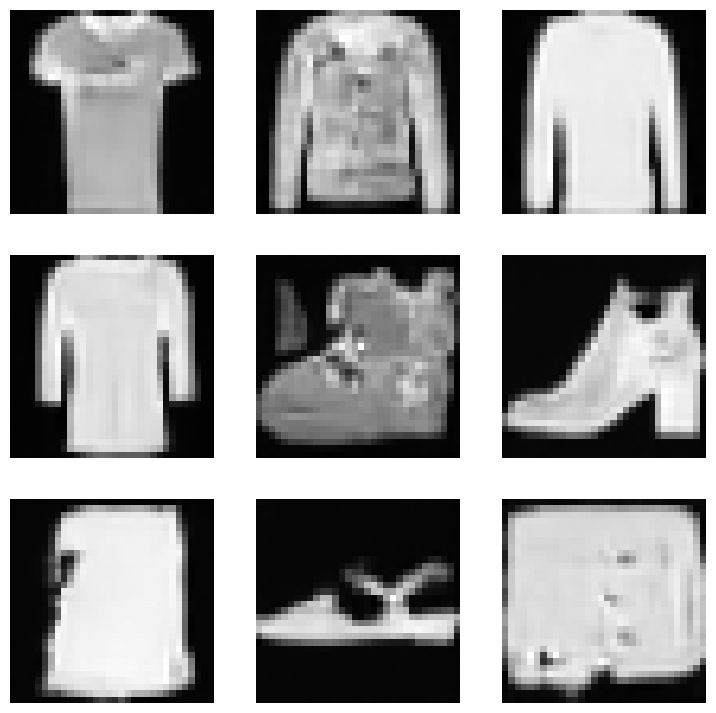

In [ ]:
show_images(mout.cpu()[:9])

In [ ]:
x, y = next(iter(dls.train))

In [ ]:
fid = FID(targ = x.cpu())
fid(mout.cpu())

22.772964477539062

loss,epoch,train
0.136,0,train
0.059,0,eval
0.051,1,train
0.048,1,eval
0.043,2,train
0.041,2,eval
0.040,3,train
0.039,3,eval
0.038,4,train
0.038,4,eval


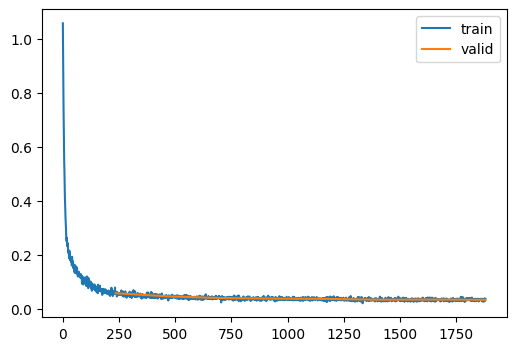

In [ ]:
# Just checking how it will fare with new linear schedule
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8

cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = torch.linspace(0.0001, 0.01, 1000)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

In [ ]:
mout = ddim_sample(model, 75, sched = DDIM_Scheduler(cbs[-2]))

100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


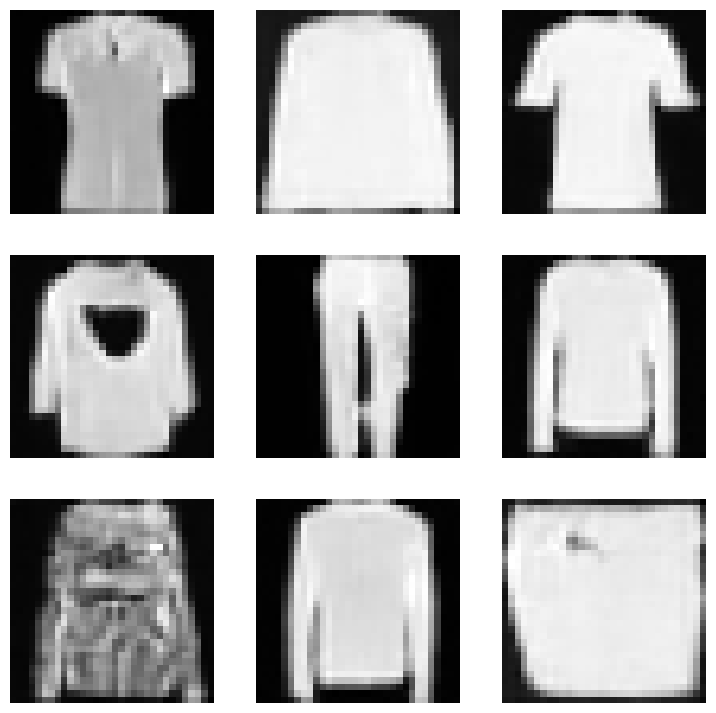

In [ ]:
show_images(mout[:9])

In [ ]:
fid(mout.cpu())

28.066558837890625